# Using Real Movie Data from Amazon

In this blog post, I will be explore the use of a collaborative filtering algorithm on a real movie dataset.

### Problem Description:

As discussed in my last post, we can make a recommender system using a collaborative filtering algorithm. This algorithm will use data obtained from [here](http://jmcauley.ucsd.edu/data/amazon/). Big thanks to Julian for giving me access to this data!

### Initialization:

First, we will need to load appropriate libraries and do a little light wrangling.

In [1]:
# Importing
import feather
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
from sklearn.decomposition import TruncatedSVD
from keras import backend as k
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

Using TensorFlow backend.


In [2]:
# Constants:
NUM_OF_REVIEWS = 5000
MIN_NUM_REVIEWS_MOVIE = 250
MIN_NUM_REVIEWS_PERSON = 10

In [3]:
# Reading data
df = feather.read_dataframe("../results/movie_df.feather")

The wrangling done below will only get movies that have reviewed a minimum amount of times. Additionally, only users that have rated a minimum amount of movies will be selected. This was mostly done because if I hadn't, I would often get a lot of obscure movie titles that I haven't heard of before. 

In [4]:
# Find number of reviewers per movie and 
# the number of movies reviewed by each person
n_reviews_movie_df = df.groupby('asin').reviewer_id.nunique()
n_reviews_person_df = df.groupby('reviewer_id').asin.nunique()

# Get list of movies that have been reviewed
# more than MIN_NUM_REVIEWS_MOVIE times and 
# users that have reviewed more than 
# MIN_NUM_REVIEWS_PERSON
popular_movies = list(n_reviews_movie_df[n_reviews_movie_df > MIN_NUM_REVIEWS_MOVIE].index)
critical_people = list(n_reviews_person_df[n_reviews_person_df > MIN_NUM_REVIEWS_PERSON].index)

# Filter dataframe to use only popular movies
# and critical people:
popular_df = df[df['asin'].isin(popular_movies)]
popular_df = popular_df[popular_df['reviewer_id'].isin(critical_people)]

# Shuffle data:
popular_df = shuffle(popular_df, random_state=42)

# Peak at data:
popular_df.head()

,reviewer_id,asin,overall,review_time,title,price
1393425,A328S9RN3U5M68,B00005JMFQ,5.0,1068681600,Love Actually (Widescreen Edition),13.70
288400,A1NSHD4YCL5DV3,0792833236,4.0,1063497600,Raging Bull,12.70
913721,A2R9J5LULVKF6T,6304176287,4.0,998956800,Willy Wonka &amp; Chocolate Factory [VHS],3.99
860416,A335GUD1YBS31U,6303617719,5.0,998438400,French Kiss [VHS],0.99
1512736,A1TFH5Y9I9M3YN,B00005QCYC,4.0,1005091200,Jurassic Park Trilogy,36.27


Great! We now have a nice little dataframe. It's nice to see that VHS seems to be alive and kicking. 

In [5]:
# Reduce size of dataset (REMOVE LATER):
# The main issue occurs below during gradient descent.
# np.dot() takes a long time. Perhaps I can use PySpark's
# dot product. 
popular_df = popular_df.head(NUM_OF_REVIEWS)

The piece of code is a bit of an embarrassment. This will be mentioned again below, but the main reason for this was for convinence. Later, I will be taking the dot product between two matricies. If I use all of the data, this dot product will take a long time. One solution is to take advantage of distributed computing. Perhaps in my next blog post, I will explore this issue.

In [6]:
# Only take relevant columns:
rating_df = popular_df[['reviewer_id', 'asin', 'overall']]

# Obtaining number of reviewers and products reviewed:
n_reviewers = len(rating_df.reviewer_id.unique())
n_products = len(rating_df.asin.unique())

# Print results:
print("There are", n_reviewers, "reviewers")
print("There are", n_products, "products reviewed")

There are 3560 reviewers
There are 1551 products reviewed


Great, we have reviewers and movies. FYI, the reason why I am saying "product" in my code is because I was previously using other amazon product data sets available [here](http://jmcauley.ucsd.edu/data/amazon/).

Next, we are working to construct a matrix where each row is a reviewer and each column is a movie. I initially construct it as a sparse array, which I think is the correct thing to do. Unfortunately, later I simply work with it as a normal dense array. If I were to repeat this exercise, I would have liked to continue to work with it as a sparse matrix. 

In [7]:
# Creating map to map from reviewer id/asin(product id) to a number:
reviewer_map = dict(zip(np.unique(rating_df.reviewer_id), list(range(n_reviewers))))
product_map = dict(zip(np.unique(rating_df.asin), list(range(n_products))))

In [8]:
# Obtain numbers(index in sparse matrix) associated with each id:
reviewer_index = np.array([reviewer_map[reviewer_id] for reviewer_id in rating_df.reviewer_id])
product_index = np.array([product_map[asin] for asin in rating_df.asin])

In [9]:
# Obtain ratings to be put into sparse matrix:
ratings = np.array(rating_df.overall)

In [10]:
# Create sparse X matrix:
X = coo_matrix((ratings, (reviewer_index, product_index)), shape=(n_reviewers, n_products))

Great, the sparse matrix `X` has now been constructed. Let's just double check that we did everything right:

In [11]:
# Performing sanity check:
person_of_interest = reviewer_map['A328S9RN3U5M68']
product_of_interest = product_map['B00005JMFQ']

X.toarray()[person_of_interest, product_of_interest]

5.0

Great, this result makes sense.

Now, the rating data is in a sparse matrix where the rows are users and the columns are movies. Note that all values of 0 for ratings are actually missing reviews. Reviewers cannot give something 0 stars. This is because `coo_matrix` by default fills in missing values with 0.

### Making our first model:

Now, let's use gradient descent to make our first model:

In [15]:
# Set up parameters:
n_iters = 1000
alpha = 0.01
num_latent_features = 2

# Using dense array for now:
X_array = X.toarray()

The code below uses gradient descent to learn the correct values for `U` and `V`. `U` can be thought as an array where each row is associated with a specific person and each column represents some sort of learned preference of theirs. These learned preferences are the number of latent features. `V` can be thought of as an array where each column is associated with a specific movie and the rows are the learned quality of the movie. This learned quality of the movie corresponds to the learned preference of the movie. 

For example, let's first assume that one of "learned preference" happend to be a preference towards scary movies. The "learned quality" of the movie would be how scary the movie was. This is further explained in my last blog post. 

As an additional note, I am performing gradient descent a little differently than I had in my previous blog post. Essentially, these are both the same.

In [16]:
# Randomly initialize:
U = np.random.randn(n_reviewers, num_latent_features) * 1e-5
V = np.random.randn(num_latent_features, n_products) * 1e-5

# Perform gradient descent:
for i in range(n_iters):
    # Obtain predictions:
    X_hat = np.dot(U, V)     
    
    if np.isnan(X_hat[person_of_interest, product_of_interest]):
        print("ERROR")
        break
        
    # Obtain residual
    resid = X_hat - X_array
    resid[np.isnan(resid)] = 0
    
    # Calculate gradients:
    dU = np.dot(resid, V.T) 
    dV = np.dot(U.T, resid)
    
    # Update values:
    U = U - dU*alpha
    V = V - dV*alpha
    
    # Output every 10% to make sure on the right track:
    if (i%(n_iters/10) == 0):
        print("Iteration:", i, 
              "   Cost:", np.sum(resid**2), 
              "   Rating of interest:", X_hat[person_of_interest, product_of_interest])
    
X_pred = np.dot(U, V)
    

Iteration: 0    Cost: 93360.0000001    Rating of interest: 1.90893973813e-10
Iteration: 100    Cost: 92540.3338637    Rating of interest: 0.14717131487
Iteration: 200    Cost: 92486.3546961    Rating of interest: 1.19057516107
Iteration: 300    Cost: 92474.6219165    Rating of interest: 1.96765864765
Iteration: 400    Cost: 92472.5455087    Rating of interest: 2.10226001765
Iteration: 500    Cost: 92471.4063733    Rating of interest: 2.02517075751
Iteration: 600    Cost: 92469.9506994    Rating of interest: 1.8234530529
Iteration: 700    Cost: 92467.961488    Rating of interest: 1.51107277851
Iteration: 800    Cost: 92465.6479947    Rating of interest: 1.13093953942
Iteration: 900    Cost: 92463.4816496    Rating of interest: 0.764126997336


In [17]:
predicted_val = X_pred[person_of_interest, product_of_interest]
actual_val = X_array[person_of_interest, product_of_interest]
print("Actual Rating: ", actual_val)
print("Predicted Rating: ", predicted_val)

Actual Rating:  5.0
Predicted Rating:  0.477522679528


The above prediction is awful. This is because we didn't handle `nan` properly. The algorithm above is trying to account for all the zero values. The "signal" is being drowned out. To fix this is simple:

### Making our second model:

In [18]:
# Replacing zeros with nan:
X_array[X_array==0] = np.nan

# Set up parameters:
n_iters = 1000
alpha = 0.01
num_latent_features = 2

# Initialize U and V randomly
U = np.random.randn(n_reviewers, num_latent_features) * 1e-5
V = np.random.randn(num_latent_features, n_products) * 1e-5

# Perform gradient descent:
for i in range(n_iters):        
    # Obtain predictions:
    X_hat = np.dot(U, V)     
    
    if np.isnan(X_hat[person_of_interest, product_of_interest]):
        print("ERROR")
        break
        
    # Obtain residual
    resid = X_hat - X_array
    resid[np.isnan(resid)] = 0
    
    # Calculate gradients:
    dU = np.dot(resid, V.T) 
    dV = np.dot(U.T, resid)
    
    # Update values:
    U = U - dU*alpha
    V = V - dV*alpha
    
    # Output every 10% to make sure on the right track:
    if (i%(n_iters/10) == 0):
        print("Iteration:", i, 
              "   Cost:", np.sum(resid**2), 
              "   Rating of interest:", X_hat[person_of_interest, product_of_interest])
    
# Make prediction:
X_pred = np.dot(U, V)

predicted_val = X_pred[person_of_interest, product_of_interest]
actual_val = X_array[person_of_interest, product_of_interest]
print("Actual Rating: ", actual_val)
print("Predicted Rating: ", predicted_val)

Iteration: 0    Cost: 93360.0    Rating of interest: -1.06505550792e-10
Iteration: 100    Cost: 50902.6127541    Rating of interest: 5.38285985849
Iteration: 200    Cost: 7359.64612045    Rating of interest: 4.85884908364
Iteration: 300    Cost: 897.066788056    Rating of interest: 4.87233382983
Iteration: 400    Cost: 156.58492863    Rating of interest: 4.88973723326
Iteration: 500    Cost: 75.6818835324    Rating of interest: 4.91750899441
Iteration: 600    Cost: 38.0496747094    Rating of interest: 4.93817080819
Iteration: 700    Cost: 13.0631882476    Rating of interest: 4.95164697125
Iteration: 800    Cost: 10.1209025019    Rating of interest: 4.96158102444
Iteration: 900    Cost: 8.1104596063    Rating of interest: 4.96938531597
Actual Rating:  5.0
Predicted Rating:  4.97574576552


This is a huge improvement! Awesome! Next, I will try to do some analysis on these results:

### Analysis:

One idea that can be done as a result from our model is we can group movies together. We have obtained these "learned features", why not use them? So now, I will try to make a plot to visualize the learned features:

In [19]:
# Let's try to see which products are most similar to each other:
param1 = V.T[:,0]
param2 = V.T[:,1]

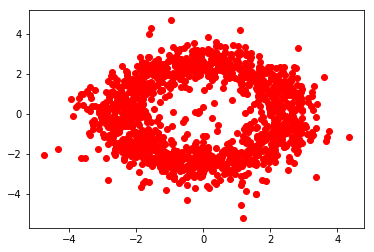

In [20]:
# Plotting the products:
plt.plot(param1, param2, 'ro')
plt.show()

Interesting, when using 2 latent-features we seem to have movies that form a circular shape! I am not sure why, but it looks interesting! Now, let's try to cluster them together to see which movies are most similar to each other:

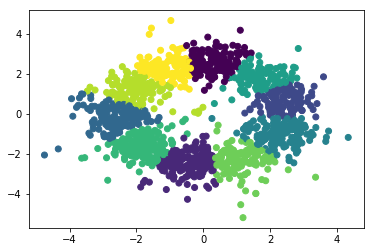

In [21]:
# Performing k-means:
kmeans = KMeans(n_clusters=10, random_state=0).fit(V.T)
groups = kmeans.labels_

# Making plot:
plt.scatter(param1, param2, c=groups)
plt.show()

Looks like a sprinkled donut. It would be nice to see concrete movie titles associated with each of these groups. This is done below:

In [22]:
# Making dictionary connecting asin to with title and group:
asin = np.unique(popular_df.asin)
product_dictionary = dict(zip(popular_df.asin, popular_df.title))
product_results = pd.DataFrame({'asin': asin})
product_results['title'] = [product_dictionary[x] for x in product_results.asin]
product_results['group'] = groups

In [23]:
# Showing group 0:
product_results[product_results.group == 0].head()

,asin,title,group
12,0767802624,Men in Black (Collector's Series),0
28,0767817478,Godzilla,0
35,0767825411,Ghostbusters [VHS],0
43,0767853636,Annie (Widescreen Edition),0
51,0780619609,Teenage Mutant Ninja Turtles II - The Secret o...,0


Maybe this group is associated with movies that are action-y?

In [24]:
# Showing group 1:
product_results[product_results.group == 1].head()

,asin,title,group
3,0767002652,Upstairs Downstairs - The Premiere Season [VHS],1
4,0767087372,Upstairs Downstairs Collector's Edition,1
6,0767736680,Home Alone/Home Alone 2 Combo Pack [VHS],1
7,076780192X,Close Encounters of the Third Kind (Widescreen...,1
21,0767809254,Steel Magnolias [VHS],1


Not sure what this group is exactly, but I'm happy that it placed the two Upstairs Downstairs titles in the same group!

In [25]:
# Showing group 2:
product_results[product_results.group == 2].head()

,asin,title,group
10,0767802535,Big Night,2
15,0767803434,Air Force One,2
33,0767824407,Immortal Beloved [VHS],2
40,0767839129,The Messenger: The Story of Joan of Arc [VHS],2
42,0767851013,Little Women (Collector's Series),2


I really have no idea as to what is occurring in this group

### Closing Notes:

Unfortunately, these groups don't seem to make immediate sense. Honestly, the trends within groups that seem to be present are probably by luck. It would be nice to see groups of movies that had an obvious theme going on such as genre or time when released. Perhaps in the future, we can make better groups if we use more latent features (we used 2 in this case). 

In future blog posts I plan to:
* Scale up to use more data
* Create a twitter bot that may be able to identify which movies are trending on social media
    * This can be used to promote movies that are trending to people that we predicted would give it a high rating. 
    * The same idea can be applied to Amazon's "Toys and Games" data set. My thought that it would be able to promote something like a fidget spinner to people which seems to be all the rage now a days. 
* Create better models be adding more features to our dataset. This can easily be done by altering our gradient descent loop. 

Please let me know if you have any other cool ideas/questions/suggestions/**found mistakes**! My e-mail is andrewlim90@gmail.com